In [113]:
import models
import numpy as np
from skimage.io import imread_collection
import torch
import glob
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from math import floor
import torch.optim as optim
from importlib import reload
reload(models)

<module 'models' from 'C:\\Users\\ifili\\MMP_MSU\\for samsung\\models.py'>

In [8]:
data = np.zeros((1000, 32, 32, 3))
Y = np.zeros(1000, dtype=np.int)
clocks = np.array(imread_collection(glob.glob("./clocks_crocodiles/clock/*.png")))
crocks = np.array(imread_collection(glob.glob("./clocks_crocodiles/crocodile/*.png")))
data[0:500, ...] = clocks
data[500:, ...] = crocks
Y[0:500] = 1
ind = np.random.permutation(1000)
data = data[ind, ...]
Y = Y[ind]
data = (data -127.5)/127.5
data = np.transpose(data, axes=(0,3,1,2))

In [27]:
test_set = torch.from_numpy(data[-100:,...])
test_y = torch.from_numpy(Y[-100:,...])
val_set = torch.from_numpy(data[-200:-100, ...])
val_y = torch.from_numpy(Y[-200:-100, ...])
train_set = torch.from_numpy(data[0:800,...])
train_y = torch.from_numpy(Y[0:800,...])

In [10]:
train = torch.utils.data.TensorDataset(train_set, train_y)
val = torch.utils.data.TensorDataset(val_set, val_y)
test = torch.utils.data.TensorDataset(test_set, test_y)

In [64]:
class CNN(nn.Module):
    def __init__(self, layers_conv, layers_class, last_c):
        super(CNN, self).__init__()
        self.l_Conv = nn.Sequential(*layers_conv)
        self.l_Class = nn.Sequential(*layers_class)
        self.size = (32, 32) 
        self.__c = last_c
        for l in self.l_Conv:
            if type(l) != type(nn.Tanh()):
                if type(l.kernel_size) != tuple:
                    k = l.kernel_size
                    s = l.stride
                    p = l.padding
                else:
                    k = l.kernel_size[0]
                    s = l.stride[0]
                    p = l.padding[0]
                self.size = self.resize(self.size, k, s, p)
    def forward(self, x):
        for l in self.l_Conv:
            x = l(x)
       # x = self.l_Conv(x)
        x = x.view(-1, self.size[0] * self.size[1] *self.__c)
        x = self.l_Class(x)
        return x
    def resize(self, size, kernel, stride, padding):
        new_size = [1, 2]
        for i in range(2):
            new_size[i] = floor((size[i] + 2*padding - (kernel - 1) -1)/stride + 1)
        return tuple(new_size)
    def imshow(img):
        img = img *127.5 + 127.5     # unnormalize
        npimg = img.numpy().astype(np.uint8)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))  


 1
 1
 0
 1
[torch.DoubleTensor of size 4]



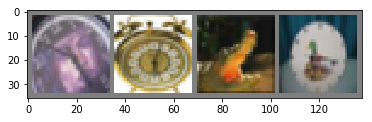

In [12]:
bs = 4
trainloader = torch.utils.data.DataLoader(train, batch_size=bs,
                                         shuffle=True, num_workers=2)
dataiter = iter(trainloader)
images, labels = dataiter.next()
models.imshow(torchvision.utils.make_grid(images))
print(labels)

In [13]:
bs=4
trainloader = torch.utils.data.DataLoader(train, batch_size=bs,
                                         shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(val, batch_size=bs,
                                         shuffle=True, num_workers=2)

_______________________________________

In [91]:
out_l = 15
acc = []
time = []
for kernel in range(2, 9):
    l_conv = [nn.Conv2d(3, out_l, kernel_size=kernel, stride=1),  nn.Tanh(), nn.MaxPool2d(2)]
    l_class = [nn.Dropout(),
            nn.Linear(out_l *int((32-kernel + 1)/2)*int((32-kernel + 1)/2), 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 2)]
    mod = CNN(l_conv, l_class, out_l)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(mod.parameters(), lr=0.001, weight_decay=1e-3)
    time.append(models.fit(mod, trainloader, criterion, optimizer))
    acc.append(models.calculate_accuracy(mod, validloader, criterion))

(31, 31)
(15, 15)
(30, 30)
(15, 15)
(29, 29)
(14, 14)
(28, 28)
(14, 14)
(27, 27)
(13, 13)
(26, 26)
(13, 13)
(25, 25)
(12, 12)


C:\Users\ifili\AppData\Local\conda\conda\envs\torch\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


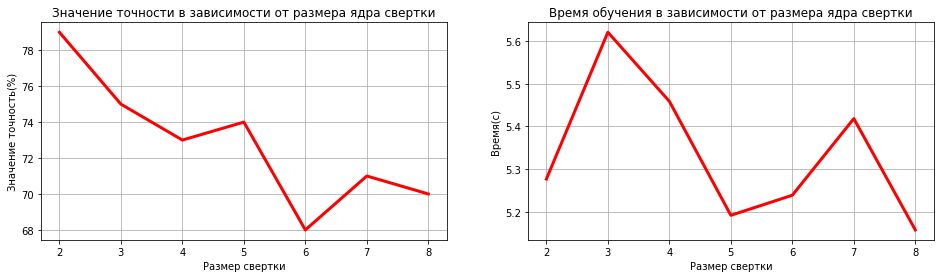

In [93]:

f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(list(range(2,9)), acc, 'r', lw=3)
ax1.set_title(u"Значение точности в зависимости от размера ядра свертки")
ax1.set_ylabel(u"Значение точность(%)")
ax1.set_xlabel(u"Размер свертки")
ax1.grid()
ax2.plot(list(range(2,9)), time, 'r', lw=3)
ax2.set_title(u"Время обучения в зависимости от размера ядра свертки")
ax2.set_ylabel(u"Время(с)")
ax2.set_xlabel(u"Размер свертки")
ax2.grid()
f.show()



In [95]:
kernel = 2
acc = []
time = []
for out_l in range(5, 40, 3):
    l_conv = [nn.Conv2d(3, out_l, kernel_size=kernel, stride=1), nn.Tanh(), nn.MaxPool2d(2)]
    l_class = [nn.Dropout(),
            nn.Linear(out_l *int((32-kernel + 1)/2)*int((32-kernel + 1)/2), 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 2)]
    mod = CNN(l_conv, l_class, out_l)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(mod.parameters(), lr=0.001, weight_decay=1e-3)
    time.append(models.fit(mod, trainloader, criterion, optimizer))
    acc.append(models.calculate_accuracy(mod, validloader, criterion))

(31, 31)
(15, 15)
(31, 31)
(15, 15)
(31, 31)
(15, 15)
(31, 31)
(15, 15)
(31, 31)
(15, 15)
(31, 31)
(15, 15)
(31, 31)
(15, 15)
(31, 31)
(15, 15)
(31, 31)
(15, 15)
(31, 31)
(15, 15)
(31, 31)
(15, 15)
(31, 31)
(15, 15)


C:\Users\ifili\AppData\Local\conda\conda\envs\torch\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


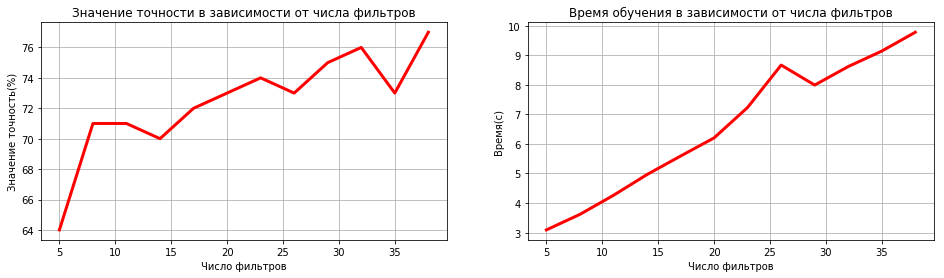

In [96]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(list(range(5,40,3)), acc, 'r', lw=3)
ax1.set_title(u"Значение точности в зависимости от числа фильтров")
ax1.set_ylabel(u"Значение точность(%)")
ax1.set_xlabel(u"Число фильтров")
ax1.grid()
ax2.plot(list(range(5,40,3)), time, 'r', lw=3)
ax2.set_title(u"Время обучения в зависимости от числа фильтров")
ax2.set_ylabel(u"Время(с)")
ax2.set_xlabel(u"Число фильтров")
ax2.grid()
f.show()  



In [97]:
kernel = 4
acc = []
time = []
out_l=38
l_conv = [nn.Conv2d(3, out_l, kernel_size=kernel, stride=1),  nn.Tanh()]
l_class = [nn.Dropout(),
        nn.Linear(out_l *int((32-kernel + 1))*int((32-kernel + 1)), 120),
        nn.ReLU(inplace=True),
        nn.Linear(120, 2)]
mod = CNN(l_conv, l_class, out_l)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mod.parameters(), lr=0.001, weight_decay=1e-3)
time.append(models.fit(mod, trainloader, criterion, optimizer))
acc.append(models.calculate_accuracy(mod, validloader, criterion))

(29, 29)


In [98]:
print(acc[0], time[0])

85.0 23.55656886100769


In [99]:
kernel = 4
acc = []
time = []
inner = [40, 60, 80, 100, 120, 140, 160]
for i in inner:
    l_conv = [nn.Conv2d(3, out_l, kernel_size=kernel, stride=1),  nn.Tanh()]
    l_class = [nn.Dropout(),
            nn.Linear(out_l *(32-kernel + 1)*(32-kernel + 1), i),
            nn.ReLU(inplace=True),
            nn.Linear(i, 2)]
    mod = CNN(l_conv, l_class, out_l)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(mod.parameters(), lr=0.001, weight_decay=1e-3)
    time.append(models.fit(mod, trainloader, criterion, optimizer))
    acc.append(models.calculate_accuracy(mod, validloader, criterion))

(29, 29)
(29, 29)
(29, 29)
(29, 29)
(29, 29)
(29, 29)
(29, 29)


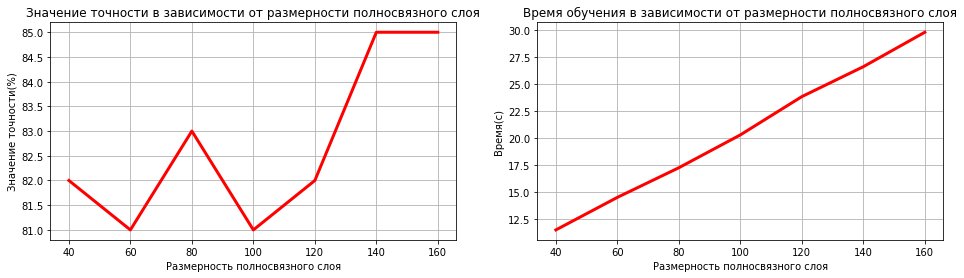

In [100]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(inner, acc, 'r', lw=3)
ax1.set_title(u"Значение точности в зависимости от размерности полносвязного слоя")
ax1.set_ylabel(u"Значение точности(%)")
ax1.set_xlabel(u"Размерность полносвязного слоя")
ax1.grid()
ax2.plot(inner, time, 'r', lw=3)
ax2.set_title(u"Время обучения в зависимости от размерности полносвязного слоя")
ax2.set_ylabel(u"Время(с)")
ax2.set_xlabel(u"Размерность полносвязного слоя")
ax2.grid()


In [101]:
kernel = 4
inner = 140
acc = []
time = []
drops = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
for p in drops:
    l_conv = [nn.Conv2d(3, out_l, kernel_size=kernel, stride=1),  nn.Tanh()]
    l_class = [nn.Dropout(p=p),
            nn.Linear(out_l *(32-kernel + 1)*(32-kernel + 1), i),
            nn.ReLU(inplace=True),
            nn.Linear(i, 2)]
    mod = CNN(l_conv, l_class, out_l)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(mod.parameters(), lr=0.001, weight_decay=1e-3)
    time.append(models.fit(mod, trainloader, criterion, optimizer))
    acc.append(models.calculate_accuracy(mod, validloader, criterion))

(29, 29)
(29, 29)
(29, 29)
(29, 29)
(29, 29)
(29, 29)
(29, 29)
(29, 29)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
C:\Users\ifili\AppData\Local\conda\conda\envs\torch\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


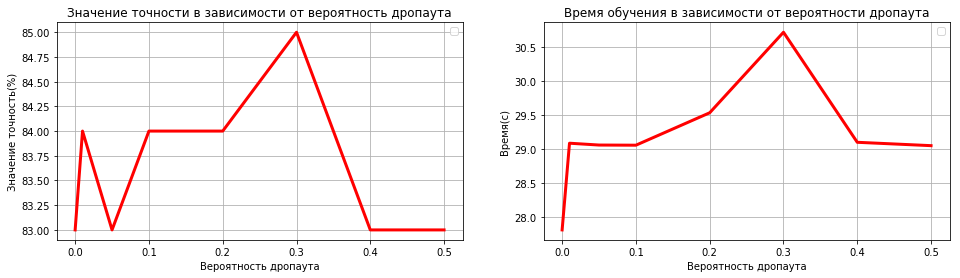

In [102]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(drops, acc, 'r', lw=3)
ax1.set_title(u"Значение точности в зависимости от вероятность дропаута")
ax1.set_ylabel(u"Значение точность(%)")
ax1.set_xlabel(u"Вероятность дропаута")
ax1.grid()
ax1.legend()
ax2.plot(drops, time, 'r', lw=3)
ax2.set_title(u"Время обучения в зависимости от вероятности дропаута")
ax2.set_ylabel(u"Время(с)")
ax2.set_xlabel(u"Вероятность дропаута")
ax2.grid()
ax2.legend()

f.show()

In [106]:
momentum = [0.9, 0.75, 0.5, 0.1, 1e-2, 1e-3, 1e-4, 1e-5, 0][::-1]
times = []
acc = []
for m in momentum:
    l_conv = [nn.Conv2d(3, out_l, kernel_size=kernel, stride=1),  nn.Tanh()]
    l_class = [nn.Dropout(p=0.3),
           nn.Linear(out_l *(32-kernel + 1)*(32-kernel + 1), i),
            nn.ReLU(inplace=True),
            nn.Linear(i, 2)]
    mod = CNN(l_conv, l_class, out_l)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(mod.parameters(), lr=0.001, weight_decay=1e-3, momentum=m)
    times.append(models.fit(mod, trainloader, criterion, optimizer))
    acc.append(models.calculate_accuracy(mod, testloader, criterion))

(29, 29)
(29, 29)
(29, 29)
(29, 29)
(29, 29)
(29, 29)
(29, 29)
(29, 29)
(29, 29)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
C:\Users\ifili\AppData\Local\conda\conda\envs\torch\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


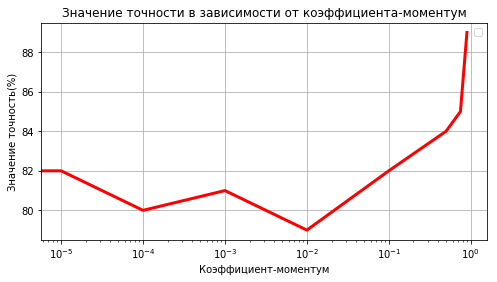

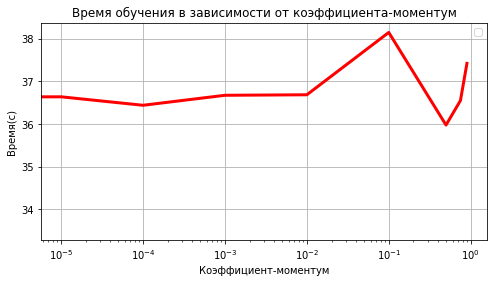

In [107]:


f, ax1,  = plt.subplots( figsize=(8,4))
plt.xscale('log')
ax1.plot(momentum, acc, 'r', lw=3)
ax1.set_title(u"Значение точности в зависимости от коэффициента-моментум")
ax1.set_ylabel(u"Значение точность(%)")
ax1.set_xlabel(u"Коэффициент-моментум")
ax1.grid()
ax1.legend()

f1, ax2,  = plt.subplots( figsize=(8,4))
plt.xscale('log')
ax2.plot(momentum, times, 'r', lw=3)

ax2.set_title(u"Время обучения в зависимости от коэффициента-моментум")
ax2.set_ylabel(u"Время(с)")
ax2.set_xlabel(u"Коэффициент-моментум")
ax2.grid()
ax2.legend()
f1.show()



In [118]:
testloader = torch.utils.data.DataLoader(test, batch_size=bs,
                                         shuffle=True, num_workers=2)
p=0.3
l_conv = [nn.Conv2d(3, out_l, kernel_size=kernel, stride=1),  nn.Tanh()]
l_class = [nn.Dropout(p=p),
           nn.Linear(out_l *(32-kernel + 1)*(32-kernel + 1), i),
            nn.ReLU(inplace=True),
            nn.Linear(i, 2)]
mod = CNN(l_conv, l_class, out_l)
mod = mod.float()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mod.parameters(), lr=0.001, weight_decay=1e-3, momentum=0.9)
models.fit(mod, trainloader, criterion, optimizer)
print("Accuracy on train", models.calculate_accuracy(mod, trainloader, criterion))
print("Accuracy on val",models.calculate_accuracy(mod, validloader, criterion))
print("Accuracy on test",models.calculate_accuracy(mod, testloader, criterion))

(29, 29)
Accuracy on train 93.125
Accuracy on val 82.0
Accuracy on test 87.0


In [120]:
data.shape

(1000, 3, 32, 32)

In [123]:
from torch.autograd import Variable
tmp = Variable(torch.ones(1, 3, 32, 32))
mod(tmp)

Variable containing:
-6.2703  5.2423
[torch.FloatTensor of size 1x2]

In [125]:
torch.max(mod(tmp), 1)

(Variable containing:
  5.1315
 [torch.FloatTensor of size 1], Variable containing:
  1
 [torch.LongTensor of size 1])